# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [40]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>% 
    group_by(character, episode_number) %>% 
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>% 
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

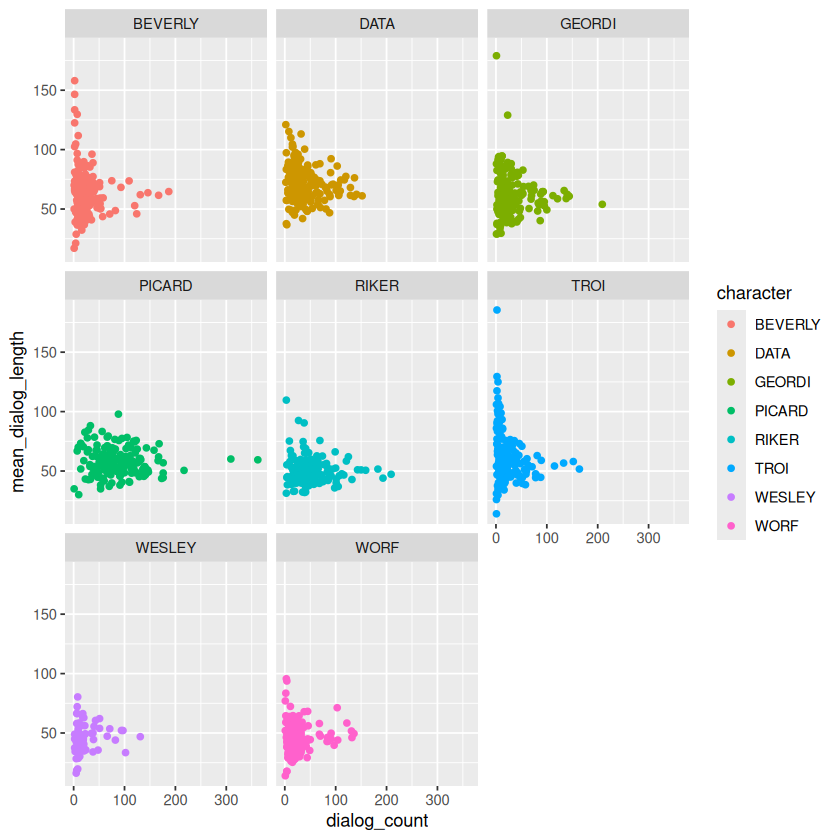

In [9]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + 
    geom_point(aes(color=character)) + 
    facet_wrap(~character)

In [ ]:
By plotting the data on the distribution of dialog count and mean dialog length, we can tell the impotance of the characters. Characters with a higher dialog count and higher mean dialog
length are important in the story. For example, Picard and Data are importanct characters due to their dialog count and dialog length. Grordi also seems to be an important character.
Wesley ans Worf seem less important characters

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`. 
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season. 

In [16]:
bev_dialog <- dialogs %>%
  filter(
    character == "BEVERLY", 
      (episode_number >= 102 & episode_number <= 126) |
       (episode_number >= 149 & episode_number <= 174)
       ) %>%
      mutate(
          season = case_when(
              between(episode_number, 102, 126) ~ "Season 1",
              between(episode_number, 149, 174) ~ "Season 3"
              )
          )
if (!"dialog_length" %in% names(bev_dialog)) {
  bev_dialog <- bev_dialog %>% mutate(dialog_length = nchar(dialog))
}

per_episode <- bev_dialog %>%
   group_by(season, episode_number) %>%
   summarize(
       mean_dialog_length = mean(dialog_length, na.rm = TRUE),
       dialog_count  = n(),
       .groups = "drop"
       )

bev_seasons <- per_episode %>%
  group_by(season) %>%
  summarize(
    mean_dialog_length_per_episode = mean(mean_dialog_length, na.rm = TRUE),
    mean_dialog_count_per_episode  = mean(dialog_count, na.rm = TRUE),
    n_episodes = n(),
    .groups = "drop"
  ) %>%
  arrange(season)

bev_seasons

season,mean_dialog_length_per_episode,mean_dialog_count_per_episode,n_episodes
<chr>,<dbl>,<dbl>,<int>
Season 1,56.48460,25.40,25
Season 3,67.04817,19.64,25


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

In [ ]:
It seems like the mean dialog count for the charecter has gone down, though the mean dialog length had risen up. This means that she speaks longer but less often. Our table reflects something about the charecter has changed between season 1 and season 3. 

## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character. 
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [19]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

tokens <- dialogs %>%
  mutate(word_list= str_split(dialog, "\\s+")) %>%
  unnest(word_list) %>%
    mutate(
    word = str_remove_all(word_list, "[[:punct:]]"), 
    word = str_to_lower(word)                         
  ) %>%
  filter(word != "", !word %in% stop_words)


#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [29]:
main_characters<- c("BEVERLY", "DATA", "PICARD", "GEORDI","RIKER", "TROI", "WESLEY", "WORF")
Words <- tokens %>%
filter (character %in% main_characters) %>%
group_by(character) %>%
summarize(
    total_words = n(),
    unique_words = n_distinct(word),
    vocabulary_richness = unique_words / total_words,
    .groups = "drop"
    ) %>%
arrange(desc(vocabulary_richness))

Words


character,total_words,unique_words,vocabulary_richness
<chr>,<int>,<int>,<dbl>
WESLEY,7590,2289,0.3015810
WORF,18795,4317,0.2296887
TROI,19434,4184,0.2152928
BEVERLY,22839,4870,0.2132318
DATA,45397,8592,0.1892636
GEORDI,31912,5456,0.1709702
RIKER,41660,6450,0.1548248
PICARD,79054,9267,0.1172237


#### c) Plot total words versus vocab richness. 
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

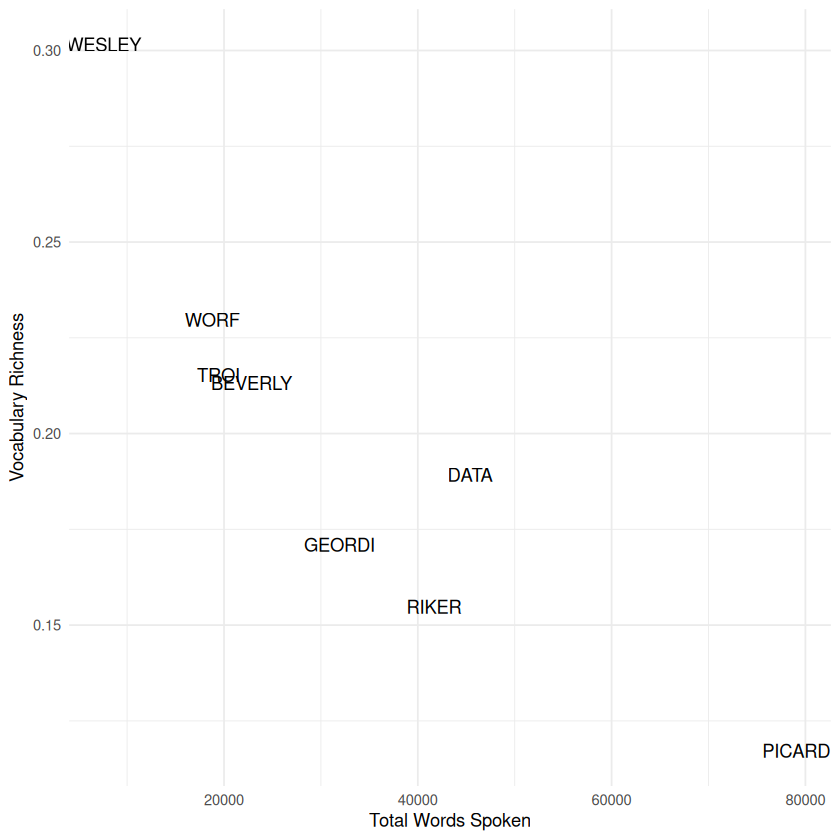

In [30]:

ggplot(Words, aes(x = total_words, y = vocabulary_richness, label = character)) +
geom_text() +
labs(
    x = "Total Words Spoken",
    y = "Vocabulary Richness"
    ) +
theme_minimal() 

#### d) Interpret these results. 

In [ ]:
Despite having the least number of of total words spoken, Wesley has the highesr vocabulary richness, indicating that wesley was a small character, providing minimal imput on each of the themes.  Picard, dispite having the most number of total words spoken, had the lowest wocabulary richness score. This would suggest that picard had many conversations regarding similar themes. All other characters had a balanced total number or words spoken and wocabulary richness score. 

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row. 
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap. 

In [32]:
wesley_dialogs <- dialogs %>%
  filter(character == "WESLEY", episode_number > 174) %>%
  group_by(episode_number) %>%
  summarize(lines = n(), .groups = "drop") %>%
  arrange(episode_number)
wesley_dialogs

episode_number,lines
<dbl>,<int>
175,18
176,6
177,9
178,6
179,38
181,2
183,94
206,131
219,71


In [ ]:
#a) Wesley left the show as a main charecter after episode 183, when he isn't dound in more than 2 episodes. 

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?
Wesley is seen again in episode 206,219,263 and 272. 

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [35]:
c
wesley_dialog <- dialogs_fixed %>%
mutate(global_order = row_number()) %>%
  filter(character == "WESLEY") %>%
  arrange(episode_number, global_order)
FIRST_GAP_EP <- 184

wesley_last_main_char <- wesley_dialog %>%
  filter(episode_number <= FIRST_GAP_EP - 1) %>%   
  slice_tail(n = 1)

wesley_last <- wesley_dialog %>%
  slice_tail(n = 1)

wesley_last_main_char
wesley_last

function (...)  .Primitive("c")

episode_number,character,dialog,dialog_length,global_order
<dbl>,<chr>,<chr>,<int>,<int>
183,WESLEY,I can walk.,11,24508


episode_number,character,dialog,dialog_length,global_order
<dbl>,<chr>,<chr>,<int>,<int>
272,WESLEY,"Good-bye, Mom.",14,49225


## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title. 
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

In [50]:
mean_char <- dialog_len_per_ep %>%
  group_by(character) %>%
  summarize(mean_char = mean(mean_dialog_length, na.rm = TRUE), .groups = "drop") %>%
  arrange(mean_char)
mean_char

character,mean_char
<chr>,<dbl>
WESLEY,45.86350
WORF,46.62378
RIKER,50.17579
PICARD,57.73758
TROI,61.49692
GEORDI,61.85890
BEVERLY,64.65250
DATA,71.72604


In [51]:
char_levels <- mean_char %>% pull(character)
mean_char <- mean_char %>%
  mutate(character = factor(character, levels = char_levels))
mean_char

dialog_len_per_ep <- dialog_len_per_ep %>%
  mutate(character = factor(character, levels = char_levels))
     

character,mean_char
<fct>,<dbl>
WESLEY,45.86350
WORF,46.62378
RIKER,50.17579
PICARD,57.73758
TROI,61.49692
GEORDI,61.85890
BEVERLY,64.65250
DATA,71.72604


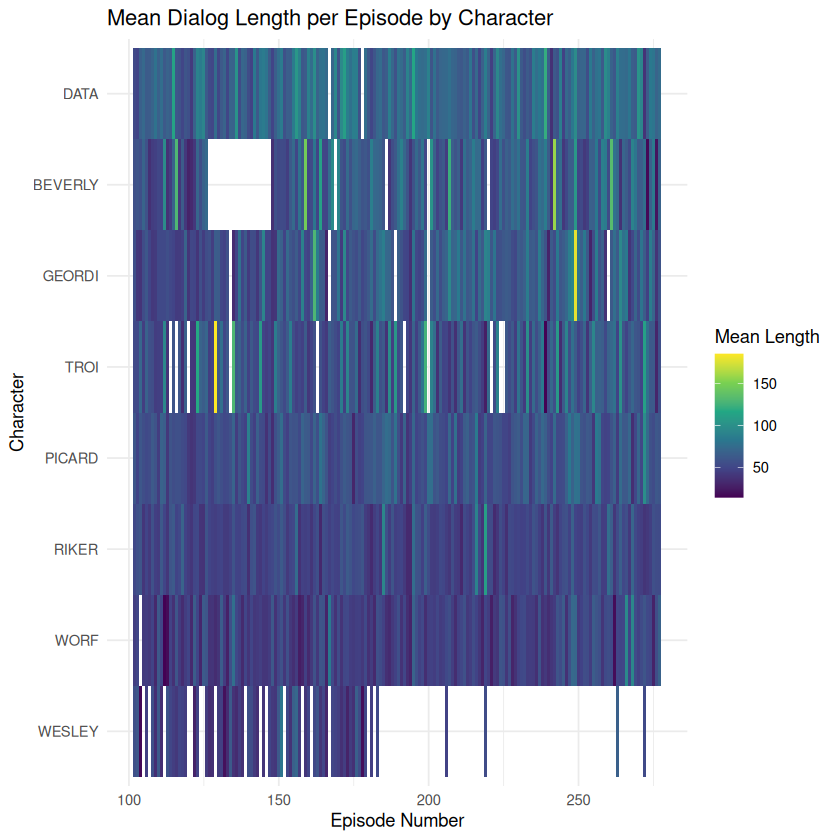

In [52]:
ggplot(dialog_len_per_ep, aes(x = episode_number, 
                              y = character, 
                              fill = mean_dialog_length)) +
  geom_tile() +
  scale_fill_viridis_c() +  # optional for nicer colors
  labs(title = "Mean Dialog Length per Episode by Character",
       x = "Episode Number",
       y = "Character",
       fill = "Mean Length") +
  theme_minimal()
     